In [2]:
import os
from glob import glob

from astropy.io import fits, ascii
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from cycler import cycler
plt.rcParams.update({
    'figure.figsize'   : (12, 10),
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   : 5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 7,
    'ytick.major.size' : 7,
    'xtick.major.width': 3,
    'ytick.major.width': 3,
    'xtick.minor.size' : 5,
    'ytick.minor.size' : 5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'lines.linewidth'  : 3,
    'axes.prop_cycle'  : cycler('color', ['red', 'orange', 'teal', 'skyblue']),
})

def Table_to_array(table):
    tuple_data = table.as_array()
    list_data  = [list(values) for values in tuple_data]
    array_data = np.array(list_data, dtype = np.float32)

    return array_data

def normalized_arrays(x_values, y_values):
    dx = x_values[1:] - x_values[:-1]
    norm_factor = np.sum(y_values[:-1] * dx)
    norm_y_values = y_values/norm_factor
    return x_values, norm_y_values

In [3]:
with fits.open('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_SOM_r50_01Aug24.fits') as cat:
    KiDS_predicted = Table(cat[1].data)

In [3]:
labeled_map = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/labeled_map.npy',
                      allow_pickle = True)
labeled_map_values = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/labeled_map_values.npy',
                      allow_pickle = True)
data_bmus = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/labeling_bmus.npy',
                      allow_pickle = True)

In [4]:
steps = 250
min_z = 0; max_z = 0.4
min_mstar = 6; max_mstar = 12

In [5]:
def gauss(x, mu, sigma): return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2/(2 * sigma**2))

Text(0.5, 0, '$z$')

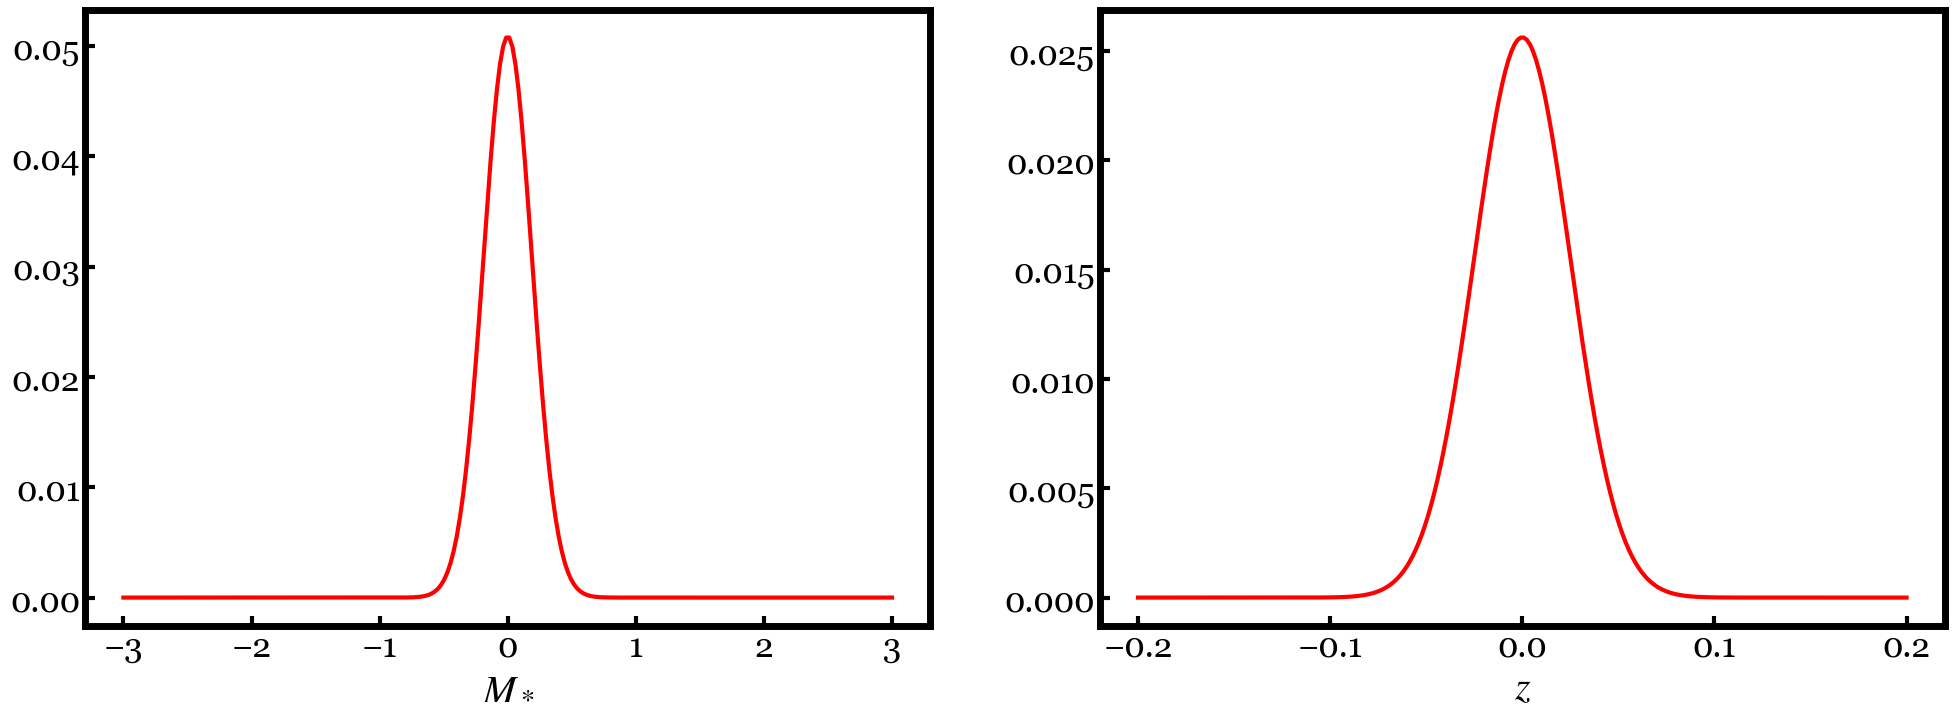

In [6]:
redshift_sigma = 0.025
redshift_gaussian = 1/np.sqrt(2 * np.pi * redshift_sigma ** 2) *\
                    np.exp(-(np.linspace(min_z, max_z, steps) - (max_z - min_z)/2) ** 2/(2 * redshift_sigma**2))
redshift_gaussian /= np.sum(redshift_gaussian)

mstar_sigma = 0.189
mstar_gaussian = 1/np.sqrt(2 * np.pi * mstar_sigma ** 2) *\
                 np.exp(-(np.linspace(min_mstar, max_mstar, steps) - (max_mstar + min_mstar)/2) ** 2/(2 * mstar_sigma**2))
mstar_gaussian /= np.sum(mstar_gaussian)

fig = plt.figure(figsize = (24, 8))
ax_l = fig.add_subplot(121)
ax_l.plot(np.linspace(min_mstar, max_mstar, steps) - (max_mstar + min_mstar)/2, mstar_gaussian)
ax_l.set_xlabel('$M_*$')

ax_r = fig.add_subplot(122)
ax_r.plot(np.linspace(min_z, max_z, steps) - (min_z + max_z)/2, redshift_gaussian)
ax_r.set_xlabel('$z$')

In [7]:
mstar_lo = labeled_map[..., 1] < 8.75
mstar_md = (labeled_map[..., 1] >= 8.75) & (labeled_map[..., 1] < 9.5)
mstar_hi = labeled_map[..., 1] >= 9.5

In [8]:
#mstar lo bin
#redshift
mstar_lo_zs = labeled_map_values[mstar_lo, 0]
mstar_lo_z_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_lo_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_lo_z_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_lo_z_dist /= np.sum(weights)

#mstar
mstar_lo_mstars = labeled_map_values[mstar_lo, 1]
mstar_lo_mstar_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_lo_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_lo_mstar_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_lo_mstar_dist /= np.sum(weights)

In [9]:
#mstar md bin
#redshift
mstar_md_zs = labeled_map_values[mstar_md, 0]
mstar_md_z_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_md_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_md_z_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_md_z_dist /= np.sum(weights)

#mstar
mstar_md_mstars = labeled_map_values[mstar_md, 1]
mstar_md_mstar_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_md_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_md_mstar_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_md_mstar_dist /= np.sum(weights)

In [10]:
#mstar hi bin
#redshift
mstar_hi_zs = labeled_map_values[mstar_hi, 0]
mstar_hi_z_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_hi_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_hi_z_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_hi_z_dist /= np.sum(weights)

#mstar
mstar_hi_mstars = labeled_map_values[mstar_hi, 1]
mstar_hi_mstar_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_hi_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_hi_mstar_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_hi_mstar_dist /= np.sum(weights)

In [11]:
x_z = np.linspace(min_z, max_z, steps)
z_pdf_lo = mstar_lo_z_dist/np.sum(mstar_lo_z_dist)
z_exp_lo = np.dot(x_z, z_pdf_lo)

z_pdf_md = mstar_md_z_dist/np.sum(mstar_md_z_dist)
z_exp_md = np.dot(x_z, z_pdf_md)

z_pdf_hi = mstar_hi_z_dist/np.sum(mstar_hi_z_dist)
z_exp_hi = np.dot(x_z, z_pdf_hi)

x_mstar = np.linspace(min_mstar, max_mstar, steps)
mstar_pdf_lo = mstar_lo_mstar_dist/np.sum(mstar_lo_mstar_dist)
mstar_exp_lo = np.dot(x_mstar, mstar_pdf_lo)

mstar_pdf_md = mstar_md_mstar_dist/np.sum(mstar_md_mstar_dist)
mstar_exp_md = np.dot(x_mstar, mstar_pdf_md)

mstar_pdf_hi = mstar_hi_mstar_dist/np.sum(mstar_hi_mstar_dist)
mstar_exp_hi = np.dot(x_mstar, mstar_pdf_hi)

In [12]:
KiDS_SOM_n_z_bin1 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO1_Nz.asc')
KiDS_SOM_n_z_bin2 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO2_Nz.asc')
KiDS_SOM_n_z_bin3 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO3_Nz.asc')
KiDS_SOM_n_z_bin4 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO4_Nz.asc')
KiDS_SOM_n_z_bin5 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO5_Nz.asc')

<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/var/tmp/lsajkov/ipykernel_3282680/2880343463.py:36: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_3282680/2880343463.py:37: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_ylabel('$p(\log_{10}(M_*/M_{\odot}))$')


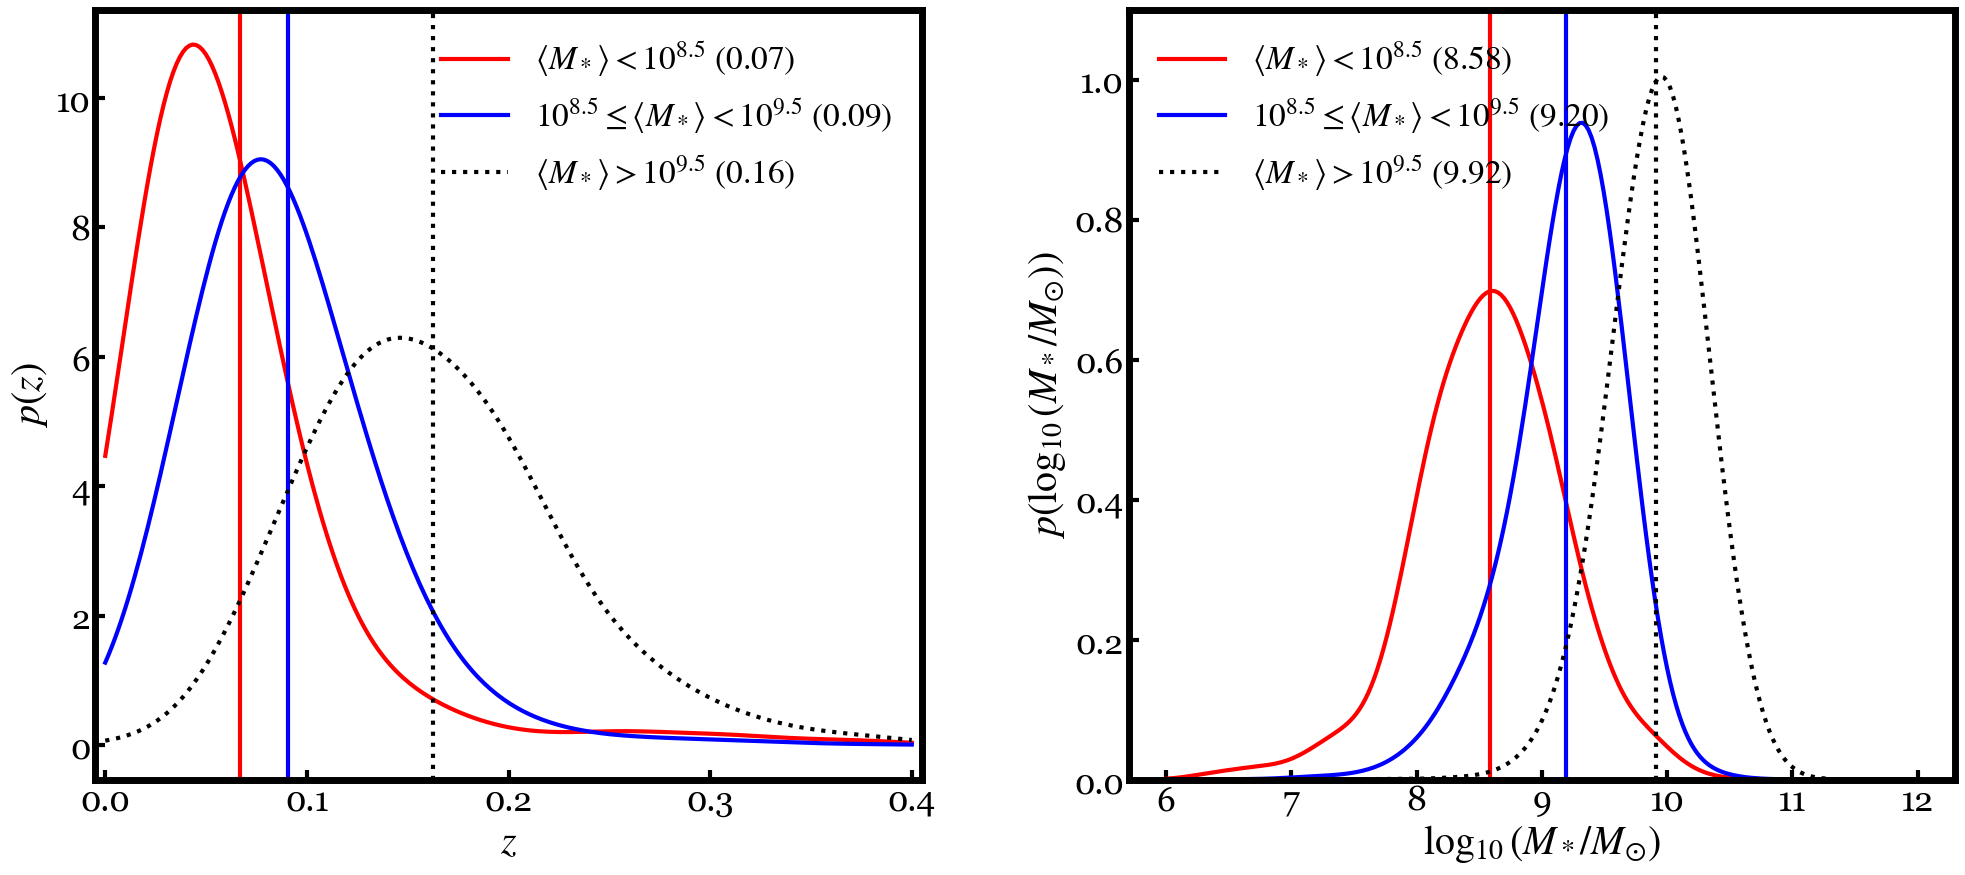

In [13]:
fig = plt.figure(figsize = (24, 10))
ax_l = fig.add_subplot(121)

ax_l.plot(*normalized_arrays(x_z, z_pdf_lo),
    color = 'red', label = rf'$\langle M_* \rangle < 10^{{8.5}}\ ({z_exp_lo:.2f})$')
ax_l.axvline(z_exp_lo, color = 'red')

ax_l.plot(*normalized_arrays(x_z, z_pdf_md), color = 'blue', label = rf'$10^{{8.5}} \leq \langle M_* \rangle < 10^{{9.5}}\ ({z_exp_md:.2f})$')
ax_l.axvline(z_exp_md, color = 'blue')

ax_l.plot(*normalized_arrays(x_z, z_pdf_hi), color = 'black', linestyle = ':', label = rf'$\langle M_* \rangle > 10^{{9.5}}\ ({z_exp_hi:.2f})$')
ax_l.axvline(z_exp_hi, color = 'black', linestyle = ':')

ax_l.set_xlim(-0.005, 0.405)
# ax_l.set_ylim(0, 0.270)

ax_l.set_xlabel('$z$')
ax_l.set_ylabel('$p(z)$')

ax_l.legend(frameon = False)

ax_r = fig.add_subplot(122)

ax_r.plot(*normalized_arrays(x_mstar, mstar_pdf_lo), color = 'red', label = rf'$\langle M_* \rangle < 10^{{8.5}}\ ({mstar_exp_lo:.2f})$')
ax_r.axvline(mstar_exp_lo, color = 'red')

ax_r.plot(*normalized_arrays(x_mstar, mstar_pdf_md), color = 'blue', label = rf'$10^{{8.5}} \leq \langle M_* \rangle < 10^{{9.5}}\ ({mstar_exp_md:.2f})$')
ax_r.axvline(mstar_exp_md, color = 'blue')

ax_r.plot(*normalized_arrays(x_mstar, mstar_pdf_hi), color = 'black', linestyle = ':', label = fr'$\langle M_* \rangle > 10^{{9.5}}\ ({mstar_exp_hi:.2f})$')
ax_r.axvline(mstar_exp_hi, color = 'black', linestyle = ':')

ax_r.set_ylim(0, 1.1)
# ax_r.set_yticklabels([])

ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
ax_r.set_ylabel('$p(\log_{10}(M_*/M_{\odot}))$')

ax_r.legend(frameon = False)

fig.subplots_adjust(wspace = 0.25)

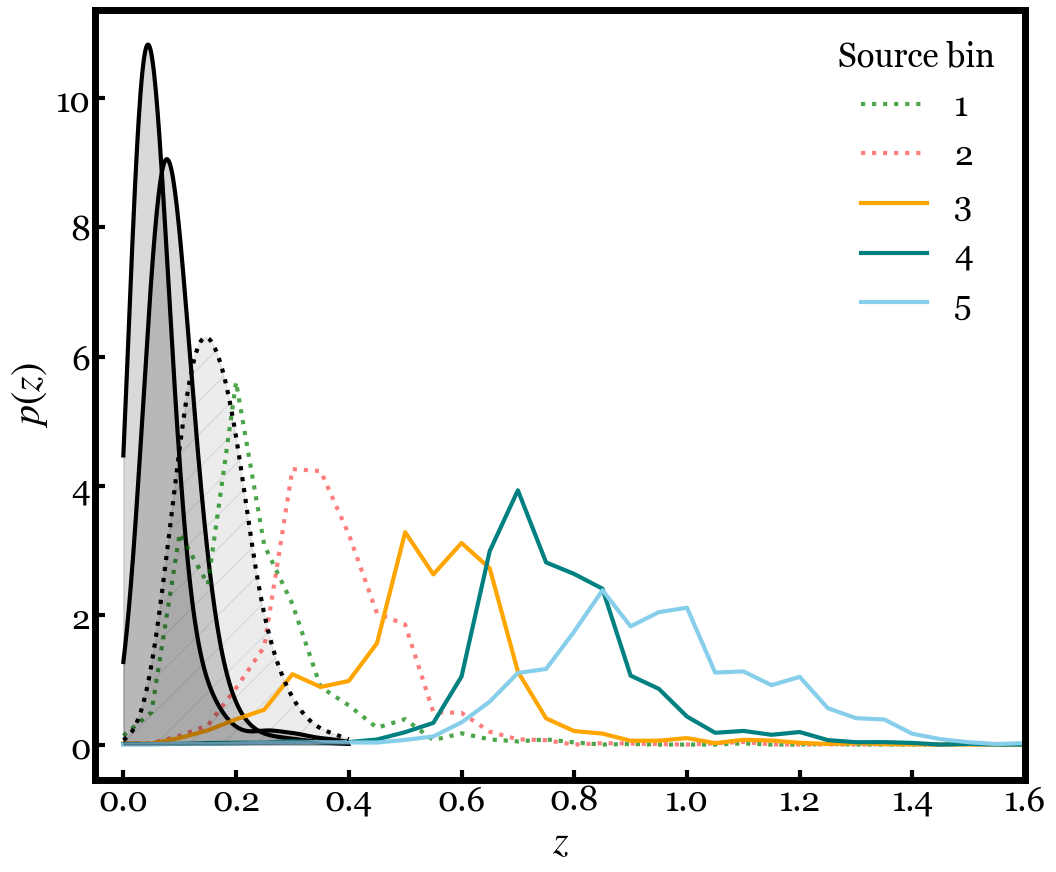

In [14]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(*normalized_arrays(x_z, z_pdf_lo), color = 'black')
ax.fill_between(*normalized_arrays(x_z, z_pdf_lo), color = 'black', alpha = 0.15, zorder = 10)

# ax.plot(x_z, z_pdf_lo/np.sum(z_pdf_lo * x_z), color = 'black')
# ax.fill_between(x_z, z_pdf_lo/np.sum(z_pdf_lo * x_z), color = 'black', alpha = 0.2, zorder = 10)

ax.plot(*normalized_arrays(x_z, z_pdf_md), color = 'black')
ax.fill_between(*normalized_arrays(x_z, z_pdf_md), color = 'black', alpha = 0.15, zorder = 11)

# ax.plot(x_z, z_pdf_md/np.sum(z_pdf_md * x_z), color = 'black')
# ax.fill_between(x_z, z_pdf_md/np.sum(z_pdf_md * x_z), color = 'black', alpha = 0.2, zorder = 11)

ax.plot(*normalized_arrays(x_z, z_pdf_hi), color = 'black', linestyle = ':', zorder = 12)
ax.fill_between(*normalized_arrays(x_z, z_pdf_hi), color = 'black', alpha = 0.075, hatch = '/')

# ax.plot(x_z, z_pdf_hi/np.sum(z_pdf_hi * x_z), color = 'black', linestyle = ':', zorder = 12)
# ax.fill_between(x_z, z_pdf_hi/np.sum(z_pdf_hi * x_z), color = 'black', alpha = 0.1, hatch = '/')

ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2']),
        alpha = 0.7, linestyle = ':', label = '1', color = 'green')
# ax.fill_between(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2'], color = 'lightgreen', alpha = 0.2, hatch = '/', facecolor = 'none')
ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2']),
        alpha = 0.5, linestyle = ':', label = '2')
# ax.fill_between(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2'], alpha = 0.2, hatch = '/', color = 'red', facecolor = 'none')

ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin3['col1'], KiDS_SOM_n_z_bin3['col2']), label = '3')
ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin4['col1'], KiDS_SOM_n_z_bin4['col2']), label = '4')
ax.plot(*normalized_arrays(KiDS_SOM_n_z_bin5['col1'], KiDS_SOM_n_z_bin5['col2']), label = '5')

ax.set_xlim(-0.05, 1.6)

ax.set_xlabel('$z$')
ax.set_ylabel('$p(z)$')

ax.legend(title = 'Source bin', frameon = False)

(-0.05, 1.6)

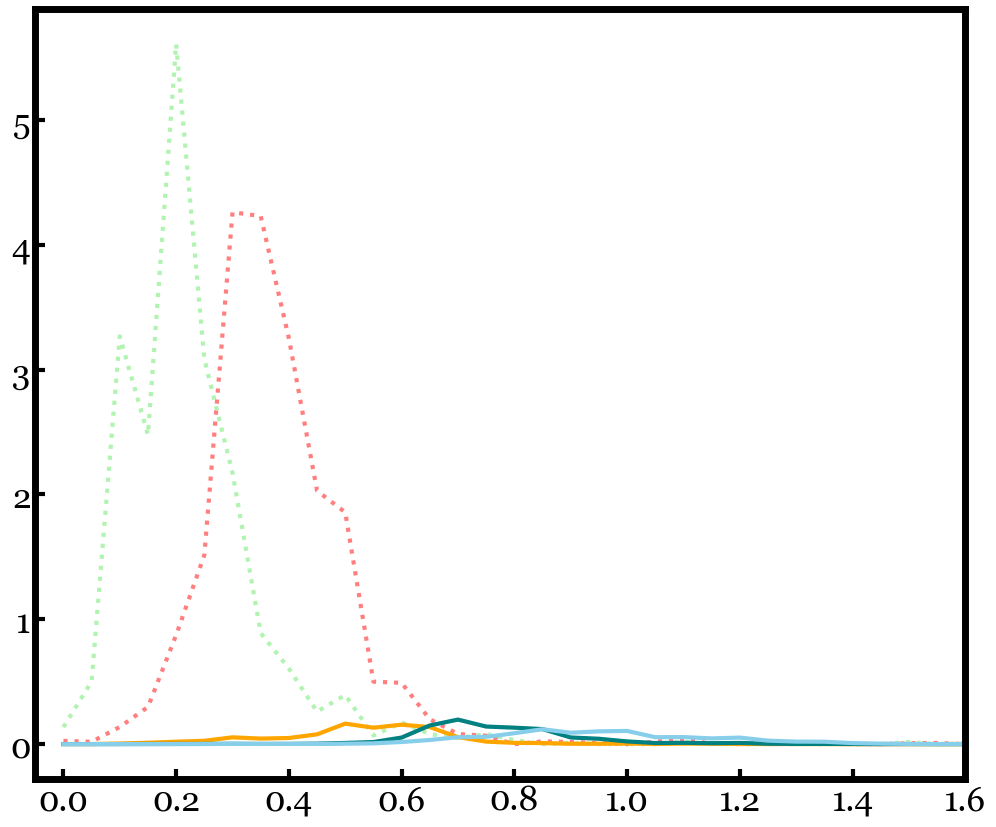

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2']/(np.sum((KiDS_SOM_n_z_bin1['col1'][1:] - KiDS_SOM_n_z_bin1['col1'][:-1]) * KiDS_SOM_n_z_bin1['col2'][:-1])),
        alpha = 0.7, linestyle = ':', label = '1', color = 'lightgreen') #/np.dot(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2'])
# ax.fill_between(KiDS_SOM_n_z_bin1['col1'], KiDS_SOM_n_z_bin1['col2'], color = 'lightgreen', alpha = 0.2, hatch = '/', facecolor = 'none')
ax.plot(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2']/(np.sum((KiDS_SOM_n_z_bin2['col1'][1:] - KiDS_SOM_n_z_bin2['col1'][:-1]) * KiDS_SOM_n_z_bin2['col2'][:-1])),
        alpha = 0.5, linestyle = ':', label = '2') #/np.dot(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2'])
# ax.fill_between(KiDS_SOM_n_z_bin2['col1'], KiDS_SOM_n_z_bin2['col2'], alpha = 0.2, hatch = '/', color = 'red', facecolor = 'none')

ax.plot(KiDS_SOM_n_z_bin3['col1'], KiDS_SOM_n_z_bin3['col2']/(np.sum((KiDS_SOM_n_z_bin2['col1'][1:] - KiDS_SOM_n_z_bin2['col1'][:-1]) * KiDS_SOM_n_z_bin2['col2'][:-1])))#/np.dot(KiDS_SOM_n_z_bin3['col1'], KiDS_SOM_n_z_bin3['col2']), label = '3')
ax.plot(KiDS_SOM_n_z_bin4['col1'], KiDS_SOM_n_z_bin4['col2']/(np.sum((KiDS_SOM_n_z_bin2['col1'][1:] - KiDS_SOM_n_z_bin2['col1'][:-1]) * KiDS_SOM_n_z_bin2['col2'][:-1])))#/np.dot(KiDS_SOM_n_z_bin4['col1'], KiDS_SOM_n_z_bin4['col2']), label = '4')
ax.plot(KiDS_SOM_n_z_bin5['col1'], KiDS_SOM_n_z_bin5['col2']/(np.sum((KiDS_SOM_n_z_bin2['col1'][1:] - KiDS_SOM_n_z_bin2['col1'][:-1]) * KiDS_SOM_n_z_bin2['col2'][:-1])))#/np.dot(KiDS_SOM_n_z_bin5['col1'], KiDS_SOM_n_z_bin5['col2']), label = '5')

ax.set_xlim(-0.05, 1.6)

In [28]:
KiDS_SOM_n_z_bin1['col2']/(np.sum(KiDS_SOM_n_z_bin1['col1'][1:] - KiDS_SOM_n_z_bin1['col1'][:-1] * KiDS_SOM_n_z_bin1['col2'][:-1]))

1.9080323249610334e-05
7.028342012940406e-05
0.0004577069315773159
0.0003472329137510427
0.0007857290604066075
0.00043214252086922004
0.00030449247457366895
0.0001247675177326989
8.492137379140485e-05
3.6555925037861236e-05
5.51358118711439e-05


In [29]:
KiDS_SOM_n_z_bin1['col1'][1:] - KiDS_SOM_n_z_bin1['col1'][:-1]

0.05
0.05
0.05000000000000002
0.04999999999999999
0.04999999999999999
0.050000000000000044
0.04999999999999999
0.04999999999999999
0.04999999999999999
0.04999999999999999
0.050000000000000044


In [30]:
print(np.sum(KiDS_SOM_n_z_bin1['col1'] * KiDS_SOM_n_z_bin1['col2']))
print(np.sum(KiDS_SOM_n_z_bin2['col1'] * KiDS_SOM_n_z_bin2['col2']))
print(np.sum(KiDS_SOM_n_z_bin3['col1'] * KiDS_SOM_n_z_bin3['col2']))
print(np.sum(KiDS_SOM_n_z_bin4['col1'] * KiDS_SOM_n_z_bin4['col2']))
print(np.sum(KiDS_SOM_n_z_bin5['col1'] * KiDS_SOM_n_z_bin5['col2']))

0.23212557926563776
0.3777156420842673
0.5385978716543566
0.7668296973595783
0.9587701993652673


In [28]:
np.sum(x_z - 0.05 < 0.001)

32

In [23]:
KiDS_SOM_n_z_bin1['col1']

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5


In [29]:
print(np.sum(x_z * z_pdf_lo/np.sum(z_pdf_lo[::32] * x_z[::32])))
print(np.sum(x_z * z_pdf_md/np.sum(z_pdf_md * x_z)))
print(np.sum(x_z * z_pdf_hi/np.sum(z_pdf_hi * x_z)))
print(np.sum(KiDS_SOM_n_z_bin1['col1'] * KiDS_SOM_n_z_bin1['col2']/np.sum(KiDS_SOM_n_z_bin1['col1'] * KiDS_SOM_n_z_bin1['col2'])))

32.45214632455689
1.0
1.0000000000000002
1.0


In [19]:
mstar_lo_idx = [mstar_lo[*index] for index in data_bmus]
mstar_md_idx = [mstar_md[*index] for index in data_bmus]
mstar_hi_idx = [mstar_hi[*index] for index in data_bmus]

In [14]:
mstar_lo_catalog = KiDS_predicted[mstar_lo_idx]
mstar_md_catalog = KiDS_predicted[mstar_md_idx]
mstar_hi_catalog = KiDS_predicted[mstar_hi_idx]

In [18]:
mstar_lo_catalog.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_dwarf_galaxy_candidates/KiDS_dwarf_galaxy_bin1.fits',
                       overwrite = True)
mstar_md_catalog.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_dwarf_galaxy_candidates/KiDS_dwarf_galaxy_bin2.fits',
                       overwrite = True)
mstar_hi_catalog.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_dwarf_galaxy_candidates/KiDS_dwarf_galaxy_bin3.fits',
                       overwrite = True)

In [19]:
mstar_lo_n_z = np.array(list(zip(x_z, z_pdf_lo)))
# ascii.write(mstar_lo_n_z, '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z/mstar_lo_n_z')

mstar_md_n_z = np.array(list(zip(x_z, z_pdf_md)))
# ascii.write(mstar_lo_n_z, '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z/mstar_md_n_z')

mstar_hi_n_z = np.array(list(zip(x_z, z_pdf_hi)))
# ascii.write(mstar_lo_n_z, '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z/mstar_hi_n_z')

In [ ]:
mstar_lo = labeled_map[..., 1] < 8.75
mstar_md = (labeled_map[..., 1] >= 8.75) & (labeled_map[..., 1] < 9.5)
mstar_hi = labeled_map[..., 1] >= 9.5

Text(0.5, 0.01, '$z$')

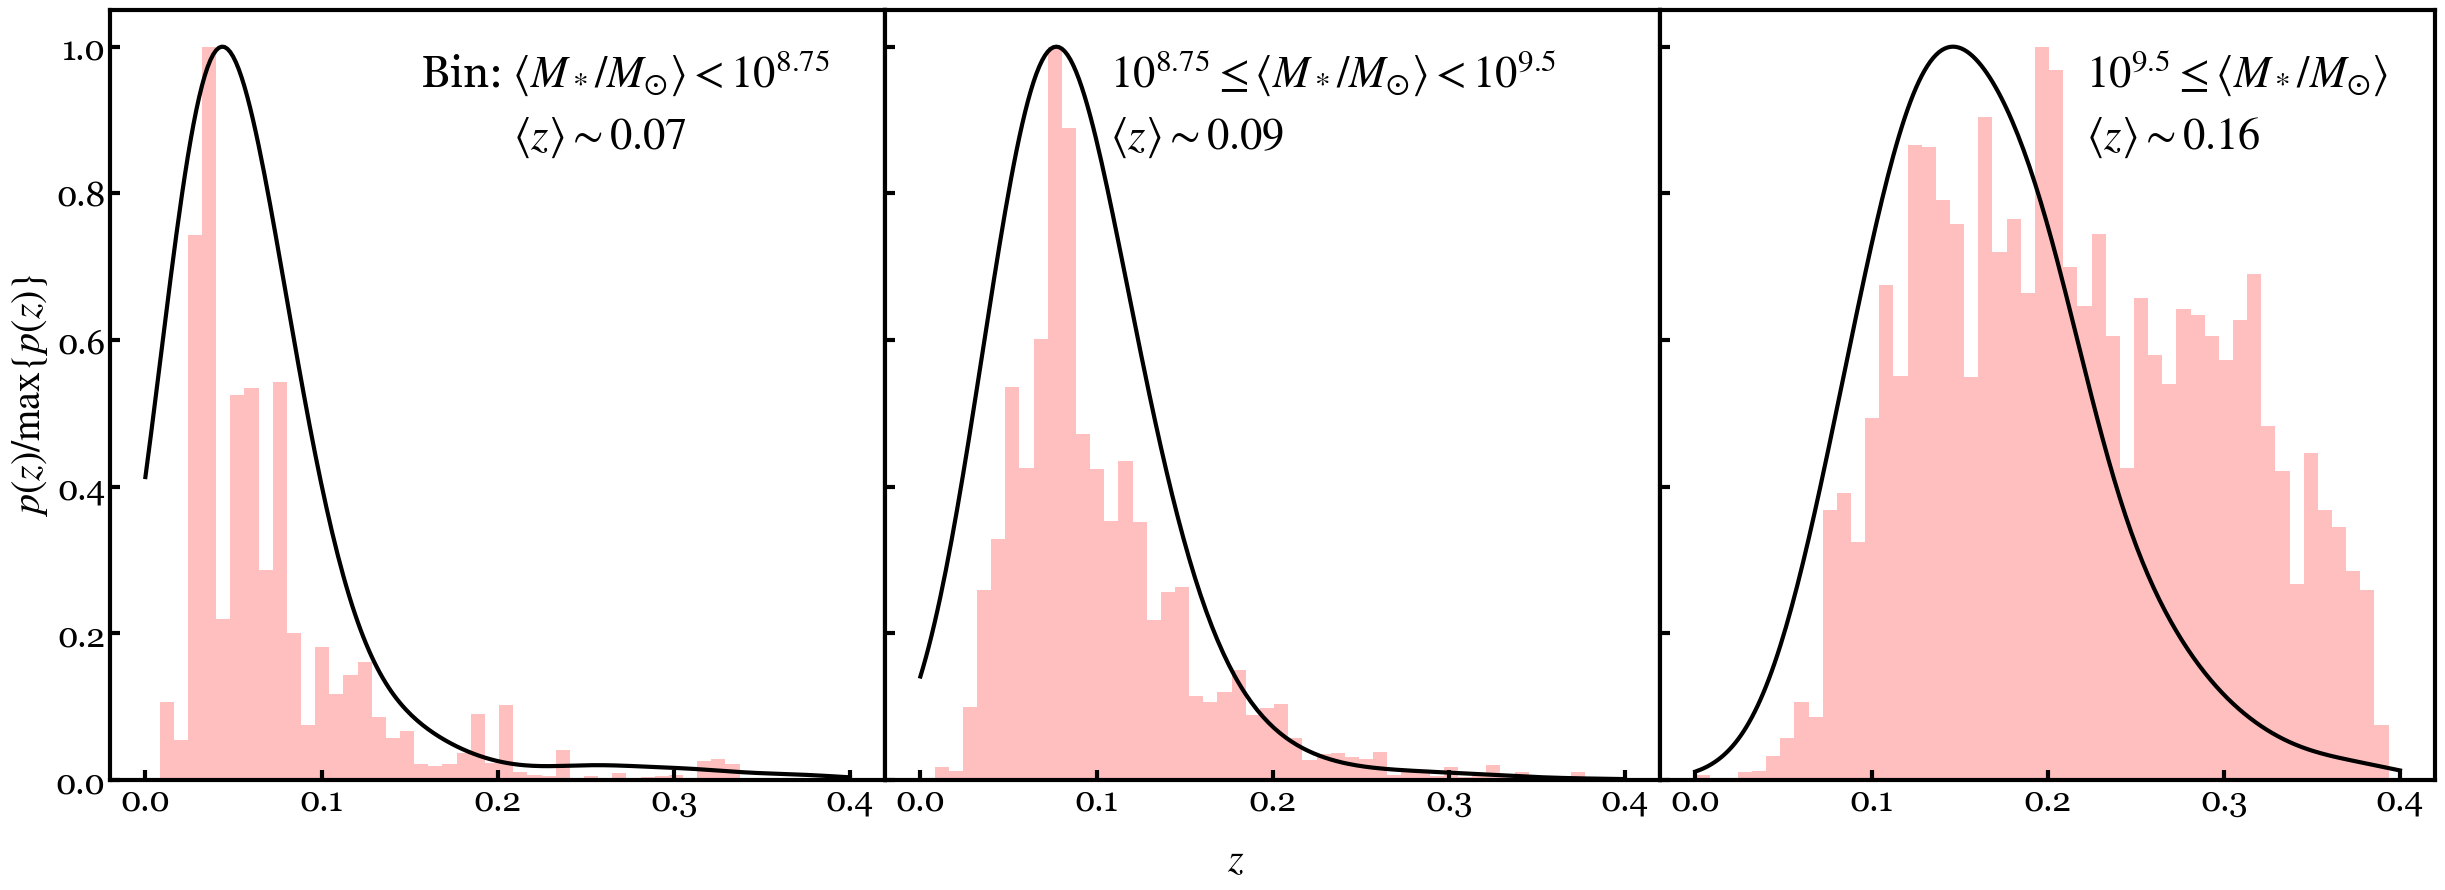

In [59]:
fig = plt.figure(figsize = (30, 10))

bins = mstar_lo_n_z[:, 0][::5]
ax_l = fig.add_subplot(131)

vals = np.histogram(mstar_lo_catalog['redshift_pred'], bins = bins)[0]
ax_l.stairs(vals/np.max(vals), bins, fill = True,
            facecolor = ('red', 0.25))
ax_l.plot(mstar_lo_n_z[:, 0], mstar_lo_n_z[:, 1]/np.max(mstar_lo_n_z[:, 1]),
          color = 'black', linewidth = 3)
ax_l.set_ylabel(r'$p(z)/{\rm max}\{p(z)\}$')

ax_l.text(0.4, 0.9,
          r'Bin: $\langle M_*/M_{\odot} \rangle < 10^{8.75}$',
          transform = ax_l.transAxes, fontsize = 32)

ax_l.text(0.52, 0.82,
          r'$\langle z \rangle \sim 0.07$',
          transform = ax_l.transAxes, fontsize = 32)

ax_l.set_ylim(0, 1.05)

ax_m = fig.add_subplot(132)

vals = np.histogram(mstar_md_catalog['redshift_pred'], bins = bins)[0]
ax_m.stairs(vals/np.max(vals), bins, fill = True,
            facecolor = ('red', 0.25))
ax_m.plot(mstar_md_n_z[:, 0], mstar_md_n_z[:, 1]/np.max(mstar_md_n_z[:, 1]),
          color = 'black', linewidth = 3)

ax_m.set_ylim(0, 1.05)
ax_m.set_yticklabels([])

ax_m.text(0.29, 0.9,
          r'$10^{8.75}\leq \langle M_*/M_{\odot} \rangle < 10^{9.5}$',
          transform = ax_m.transAxes, fontsize = 32)

ax_m.text(0.29, 0.82,
          r'$\langle z \rangle \sim 0.09$',
          transform = ax_m.transAxes, fontsize = 32)

ax_r = fig.add_subplot(133)

vals = np.histogram(mstar_hi_catalog['redshift_pred'], bins = bins)[0]
ax_r.stairs(vals/np.max(vals), bins, fill = True,
            facecolor = ('red', 0.25))
ax_r.plot(mstar_hi_n_z[:, 0], mstar_hi_n_z[:, 1]/np.max(mstar_hi_n_z[:, 1]),
          color = 'black', linewidth = 3)

ax_r.set_ylim(0, 1.05)
ax_r.set_yticklabels([])

ax_r.text(0.55, 0.9,
          r'$10^{9.5} \leq \langle M_*/M_{\odot} \rangle$',
          transform = ax_r.transAxes, fontsize = 32)

ax_r.text(0.55, 0.82,
          r'$\langle z \rangle \sim 0.16$',
          transform = ax_r.transAxes, fontsize = 32)

fig.subplots_adjust(wspace = 0)
fig.supxlabel('$z$')